In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("course_lead_scoring.csv")

# ------------- Data preparation -------------
df = df.copy()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('NA')
    else:
        df[col] = df[col].fillna(0.0)

# split into 60/20/20
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  # 0.25 * 0.8 = 0.2

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

print("Data sizes: train=%d, val=%d, test=%d" % (len(df_train), len(df_val), len(df_test)))

Data sizes: train=876, val=293, test=293


In [3]:
# ------------- Q1: ROC AUC for numerical features -------------

num_vars = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
auc_scores = {}
for col in num_vars:
    score = df_train[col].values
    auc_val = roc_auc_score(y_train, score)
    if auc_val < 0.5:
        auc_val = roc_auc_score(y_train, -score)
    auc_scores[col] = auc_val

for k,v in auc_scores.items():
    print(f"{k}: {v:.6f}")
best_num = max(auc_scores, key=auc_scores.get)
print("Best numerical variable (highest AUC):", best_num)

lead_score: 0.614499
number_of_courses_viewed: 0.763568
interaction_count: 0.738270
annual_income: 0.551958
Best numerical variable (highest AUC): number_of_courses_viewed


In [5]:
# Q2: Train logistic regression with DictVectorizer and compute validation AUC
# Prepare data: use all features except target
features = [c for c in df.columns if c != 'converted']

dv = DictVectorizer(sparse=False)
train_dicts = df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_val_pred = model.predict_proba(X_val)[:,1]
val_auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation AUC: {val_auc:.6f}")

Validation AUC: 0.817132


In [7]:
# ------------- Q3: Precision and Recall across thresholds -------------
thresholds = np.arange(0.0, 1.001, 0.01)
precisions = []
recalls = []

for t in thresholds:
    preds = (y_val_pred >= t).astype(int)
    # handle cases where precision/recall undefined -> use 0.0
    if preds.sum() == 0:
        precisions.append(0.0)
    else:
        precisions.append(precision_score(y_val, preds))
    recalls.append(recall_score(y_val, preds))

# find threshold where precision and recall intersect (closest point)
diffs = np.abs(np.array(precisions) - np.array(recalls))
min_idx = diffs.argmin()
threshold_intersect = thresholds[min_idx]
print(f"Threshold where precision and recall intersect (closest): {threshold_intersect:.3f}")

Threshold where precision and recall intersect (closest): 0.980


In [9]:
# ------------- Q4: F1 score across thresholds -------------
f1s = []
for p,r in zip(precisions, recalls):
    if p + r == 0:
        f1s.append(0.0)
    else:
        f1s.append(2 * p * r / (p + r))

f1s = np.array(f1s)
best_idx = f1s.argmax()
best_threshold_f1 = thresholds[best_idx]
best_f1 = f1s[best_idx]
print(f"Threshold with maximal F1: {best_threshold_f1:.3f}, F1={best_f1:.6f}")

Threshold with maximal F1: 0.570, F1=0.812500


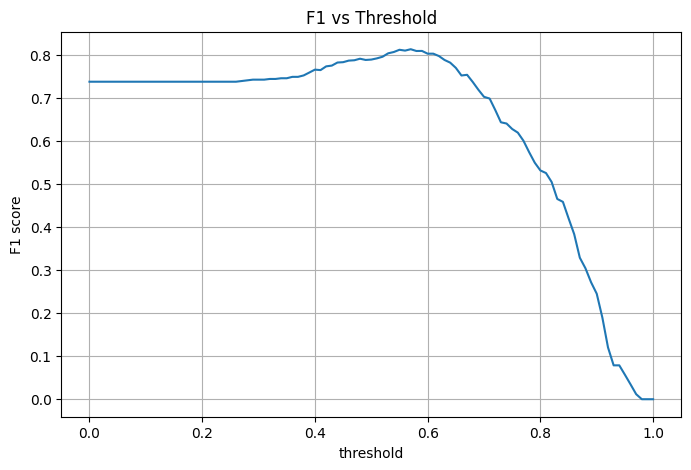

In [10]:
# Plot F1
plt.figure(figsize=(8,5))
plt.plot(thresholds, f1s, label='F1')
plt.xlabel('threshold')
plt.ylabel('F1 score')
plt.title('F1 vs Threshold')
plt.grid(True)
plt.show()

In [11]:
# ------------- Q5: 5-Fold CV on df_full_train -------------
kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

X_full = dv.transform(df_full_train[features].to_dict(orient='records'))
y_full = df_full_train['converted'].values

for train_idx, val_idx in kf.split(X_full):
    X_tr, X_va = X_full[train_idx], X_full[val_idx]
    y_tr, y_va = y_full[train_idx], y_full[val_idx]
    m = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    m.fit(X_tr, y_tr)
    y_va_pred = m.predict_proba(X_va)[:,1]
    score = roc_auc_score(y_va, y_va_pred)
    scores.append(score)

scores = np.array(scores)
print(f"CV AUC scores: {scores}")
print(f"mean = {scores.mean():.6f}, std = {scores.std():.6f}")

CV AUC scores: [0.80607459 0.87137384 0.77543201 0.80183686 0.85582727]
mean = 0.822109, std = 0.035807


In [13]:
# ------------- Q6: Hyperparameter tuning over C values -------------
C_values = [0.000001, 0.001, 1]
results = {}

for C in C_values:
    cv_scores = []
    for train_idx, val_idx in kf.split(X_full):
        X_tr, X_va = X_full[train_idx], X_full[val_idx]
        y_tr, y_va = y_full[train_idx], y_full[val_idx]
        m = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        m.fit(X_tr, y_tr)
        y_va_pred = m.predict_proba(X_va)[:,1]
        cv_scores.append(roc_auc_score(y_va, y_va_pred))
    cv_scores = np.array(cv_scores)
    results[C] = (cv_scores.mean(), cv_scores.std())

print("CV results for different C values (mean, std):")
for C, (mean_s, std_s) in results.items():
    print(f"C={C}: mean={mean_s:.6f}, std={std_s:.6f}")

# Round mean and std to 3 decimals as requested for selection
results_rounded = {C: (round(v[0],3), round(v[1],3)) for C,v in results.items()}
print("\nRounded (3 decimals):", results_rounded)

# Choose best C: highest mean; tie-breaker -> lowest std; then smallest C
best_mean = max([v[0] for v in results.values()])
candidates = [C for C,(m,s) in results.items() if np.isclose(m, best_mean)]
if len(candidates) > 1:
    # choose lowest std among candidates
    stds = {C: results[C][1] for C in candidates}
    best_C = min(stds, key=stds.get)
else:
    best_C = candidates[0]

print("\nBest C selected:", best_C)

# Final answers dictionary
answers = {
    "Q1_best_variable": best_num,
    "Q2_val_auc": val_auc,
    "Q3_threshold_intersect": threshold_intersect,
    "Q4_best_threshold_f1": best_threshold_f1,
    "Q5_cv_std": scores.std(),
    "Q6_best_C": best_C,
    "Q6_results_rounded": results_rounded
}

CV results for different C values (mean, std):
C=1e-06: mean=0.560208, std=0.023798
C=0.001: mean=0.866878, std=0.028746
C=1: mean=0.822109, std=0.035807

Rounded (3 decimals): {1e-06: (np.float64(0.56), np.float64(0.024)), 0.001: (np.float64(0.867), np.float64(0.029)), 1: (np.float64(0.822), np.float64(0.036))}

Best C selected: 0.001
